# Initialize

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import assets.config as config
import matplotlib.pyplot as plt
import csv
from datetime import datetime
import re
import numpy as np
import time
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time
import os

/Users/ryanhermes/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
ticker = 'JPM'

# Data

### Daily Info

In [3]:
if os.path.exists(f'data/{ticker}_daily.csv'):
    print('File exists')
else:
    # Define the URL and headers
    url = f"https://yahoo-finance127.p.rapidapi.com/historic/{ticker}/1d/730d"
    headers = {
        "x-rapidapi-key": "dfbe7c0a1fmshe393d06dc43c773p13ef07jsnc9ba1900f6ce",
        "x-rapidapi-host": "yahoo-finance127.p.rapidapi.com"
    }

    # Make the request
    response = requests.get(url, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        # Extract JSON data
        data = response.json()

        # Extract data
        timestamps = data['timestamp']
        close_prices = data['indicators']['quote'][0]['close']
        volumes = data['indicators']['quote'][0]['volume']

        # Convert timestamps to "yyyy-mm-dd" format
        dates = [datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d') for ts in timestamps]

        # Prepare data for CSV
        csv_data = list(zip(dates, close_prices, volumes))

        # Define CSV file path
        csv_file_path = f'data/{ticker}_daily.csv'

        # Write to CSV file
        with open(csv_file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Date', 'Close', 'Volume'])  # Header row
            writer.writerows(csv_data)

        print(f"Data written to {csv_file_path}")
    else:
        print("Error:", response.status_code)

Data written to data/JPM_daily.csv


In [4]:
# Alphavantage implementation

# url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker}&apikey={config.alphavantage_apikey}'
# r = requests.get(url)
# data = r.json()

# header = list(data['Time Series (Daily)']['2024-05-14'].keys())
# header.insert(0, 'Date')

# # Writing to CSV
# with open(f'data/{ticker}_daily.csv', 'w', newline='') as csvfile:
#     writer = csv.DictWriter(csvfile, fieldnames=header)
    
#     writer.writeheader()
    
#     for date, values in data['Time Series (Daily)'].items():
#         row = {'Date': date}
#         row.update(values)
#         writer.writerow(row)


### Insider Trades

In [5]:
url = f"http://openinsider.com/screener?s={ticker}&o=&pl=&ph=&ll=&lh=&fd=730&fdr=&td=0&tdr=&fdlyl=&fdlyh=&daysago=&xp=1&xs=1&vl=&vh=&ocl=&och=&sic1=-1&sicl=100&sich=9999&grp=0&nfl=&nfh=&nil=&nih=&nol=&noh=&v2l=&v2h=&oc2l=&oc2h=&sortcol=0&cnt=1000&page=1"

# Request the webpage
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

time.sleep(1)

# Find the table
table = soup.find('table', class_='tinytable')

if table:
    # Extract table rows
    rows = table.find_all('tr')

    # Create an empty list to store the data
    data = []

    # Loop through rows and extract data
    for row in rows[1:]:  # Skip the header row
        cells = row.find_all('td')
        insider_info = {
            'Trade Date': cells[2].get_text(strip=True),
            'Value': cells[11].get_text(strip=True)
        }
        data.append(insider_info)

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data)

    # Remove dollar sign and comma from 'Value' column and convert to numeric type
    df['Value'] = df['Value'].str.replace('$', '').str.replace(',', '').astype(float)

    # Group the data by 'Trade Date' and aggregate the values
    df_merged = df.groupby('Trade Date').agg({'Value': 'sum'}).reset_index()

    # Save DataFrame to CSV
    df_merged.to_csv(f'data/{ticker}_insider_trades.csv', index=False)
    print('Insider trades data saved')

else:
    print('No table found')

Insider trades data saved


/var/folders/b7/3syr39bd24n_5m711ln6vz800000gn/T/ipykernel_26818/485494802.py:32: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Value'] = df['Value'].str.replace('$', '').str.replace(',', '').astype(float)


### Articles

Get articles

In [6]:
chrome_options = Options()
chrome_options.add_argument("--headless")
driver = webdriver.Chrome(options=chrome_options)

article_links = []

def get_yahoo_articles():
    driver.get(f"https://finance.yahoo.com/quote/{ticker}/news")

    # Scroll down the page multiple times to load more articles
    for _ in range(5): # scroll x times
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)

    page_source = driver.page_source
    driver.quit()
    soup = BeautifulSoup(page_source, 'html.parser')

    articles = soup.find_all("li", class_="stream-item svelte-7rcxn")

    for article in articles:
        link = article.find("a")
        article_links.append(link.get("href"))

def get_nasdaq_articles():
    driver.get(f"https://www.nasdaq.com/market-activity/stocks/{ticker}/news-headlines")

    # Wait for the dynamic content to be loaded
    try:
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "jupiter22-c-article-list__item")))
        print("Page content loaded successfully.")
    except Exception as e:
        print("Error:", e)
        return

    # Once the content is loaded, get the page source
    page_source = driver.page_source

    # Parse the HTML with BeautifulSoup
    soup = BeautifulSoup(page_source, 'html.parser')
    
    # Extract article links
    articles = soup.find_all("li", class_="jupiter22-c-article-list__item")

    for article in articles:
        link = article.find("a")
        if link:
            article_links.append(link.get("href"))

    # Print the article links
    print("Article links:", article_links)

get_yahoo_articles()
#get_nasdaq_articles()

print(article_links)

['https://finance.yahoo.com/video/jpmorgans-dimon-goldmans-solomon-voice-140347356.html', 'https://finance.yahoo.com/news/jpmorgan-failed-monitor-billions-client-224013670.html', 'https://finance.yahoo.com/news/jpmorgan-pay-100-million-over-214848642.html', 'https://finance.yahoo.com/news/orsted-receives-650-million-tax-170001089.html', 'https://finance.yahoo.com/news/top-midday-stories-nvidia-earnings-160557326.html', 'https://finance.yahoo.com/news/jpmorgan-jpm-pay-100m-penalty-160400698.html', 'https://finance.yahoo.com/news/jpmorgan-hunts-private-credit-firm-104944793.html', 'https://finance.yahoo.com/news/market-chatter-jamie-dimon-discloses-125538864.html', 'https://finance.yahoo.com/m/bfbb9f8e-64ca-3210-8e3c-8f00ea65b7ad/washington%E2%80%99s-pivot-on-bank.html', 'https://finance.yahoo.com/news/market-chatter-jpmorgan-looking-buy-115431068.html', 'https://finance.yahoo.com/news/jamie-dimon-admits-tough-going-115312902.html', 'https://finance.yahoo.com/news/jpmorgan-chase-co-jpm-r

Get sentiment

In [7]:
def scrape_yahoo_finance(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')

        # Get header
        header_element = soup.find(id="caas-lead-header-undefined")
        header = header_element.get_text().strip()

        # Get body
        article_elements = soup.find_all(class_="caas-body")
        body = ""
        for element in article_elements: body += element.get_text().strip() + "\n"

        # Get date
        date_text = soup.find_all(class_="caas-attr-time-style")[0].get_text().strip()
        date = re.search(r'(\w{3}, \w{3} \d{1,2}, \d{4})', date_text)
        date = datetime.strptime(date.group(), "%a, %b %d, %Y").strftime("%Y-%m-%d")
        return header, body, date
    else:
        print("Failed to retrieve the webpage. Status code:", response.status_code)

def analyze(text):
    # Summarizer
    summarizer_api_url = "https://api-inference.huggingface.co/models/sshleifer/distilbart-cnn-12-6"
    summarizer_headers = {f"Authorization": f"Bearer {config.huggingface_apikey}"}
    summarizer_output = requests.post(summarizer_api_url, headers=summarizer_headers, json={"inputs": text}).json()
    text = summarizer_output[0]['summary_text']

    # Sentimentizer
    sentimentizer_api_url = "https://api-inference.huggingface.co/models/ProsusAI/finbert"
    sentimentizer_headers = {"Authorization": f"Bearer {config.huggingface_apikey}"}
    sentimentizer_output = requests.post(sentimentizer_api_url, headers=sentimentizer_headers, json={"inputs": text}).json()

    most_likely_label, max_score = None, 0
    for sentiment in sentimentizer_output[0]:
        label, score = sentiment['label'], sentiment['score']
        if score > max_score: most_likely_label, max_score = label, score
    if most_likely_label == 'positive': sentiment = 1
    elif most_likely_label == 'neutral': sentiment = 0
    else: sentiment = -1

    return sentiment, summarizer_output, sentimentizer_output

# Main engine
articledata = []
company_table = pd.read_csv('assets/companies.csv')
short_name, company_name = company_table.loc[company_table['ticker'] == ticker]['short name'].values[0], company_table.loc[company_table['ticker'] == ticker]['company name'].values[0]

for i, article in enumerate(article_links):
    
    try: 
        head, body, date = scrape_yahoo_finance(article)
        if ticker in head or short_name in head or company_name in head: pass
        else: continue
    except Exception as scrape_error:
        print(f"Failed to scrape article '{article}': {scrape_error.__class__.__name__}: {str(scrape_error)} \n")
        continue

    try: 
        sentiment, summarizer_output, sentimentizer_output = analyze(body)
    except Exception as sentiment_error:
        print(f"Failed to analyze sentiment for article '{article}': {sentiment_error.__class__.__name__}: {str(sentiment_error)} \n")
        continue

    articledata.append({'Date': date, 'Sentiment': sentiment})
    print(f"Iteration {i}: {date}, '{head}'\n- {article}\n- Summarizer output:{summarizer_output[0]['summary_text']}\n- Sentimentizer output: {sentimentizer_output[0][0]['label']} ({round(sentimentizer_output[0][0]['score'], 2)})\n")

# Convert to DataFrame
df = pd.DataFrame(articledata)

# Initialize new sentiment columns
df['Negative_Count'] = (df['Sentiment'] == -1).astype(int)
df['Neutral_Count'] = (df['Sentiment'] == 0).astype(int)
df['Positive_Count'] = (df['Sentiment'] == 1).astype(int)
df['Negative_Count'] *= -1

# Group by date and sum the counts
df_grouped = df.groupby('Date').agg({
    'Negative_Count': 'sum',
    'Neutral_Count': 'sum',
    'Positive_Count': 'sum'
}).reset_index()

# Add a total count column
df_grouped['Total_Count'] = df_grouped['Negative_Count'] + df_grouped['Positive_Count']

# Save to CSV
df_grouped.to_csv(f'data/{ticker}_sentiment.csv', index=False)

print("Success")

Failed to retrieve the webpage. Status code: 502
Failed to scrape article 'https://finance.yahoo.com/video/jpmorgans-dimon-goldmans-solomon-voice-140347356.html': TypeError: cannot unpack non-iterable NoneType object 

Iteration 1: 2024-05-23, 'JPMorgan Failed to Monitor Billions of Client Orders, CFTC Says'
- https://finance.yahoo.com/news/jpmorgan-failed-monitor-billions-client-224013670.html
- Summarizer output: JPMorgan Chase & Co. failed to properly monitor billions of client orders between 2014 and 2021, the CFTC says . The CFTC on Thursday said the bank would pay $100 million to settle a multiyear probe into the JPMorgan’s trade monitoring . The bank has already agreed to pay the Federal Reserve and Office of the Comptroller of the Currency $300 million .
- Sentimentizer output: negative (0.63)

Iteration 2: 2024-05-23, 'JPMorgan to pay $100 million over trade reporting violations'
- https://finance.yahoo.com/news/jpmorgan-pay-100-million-over-214848642.html
- Summarizer output:

# Merge

In [8]:
historical = pd.read_csv(f'data/{ticker}_daily.csv')
insider = pd.read_csv(f'data/{ticker}_insider_trades.csv')
news = pd.read_csv(f'data/{ticker}_sentiment.csv')

newdata = pd.merge(historical, insider, how='left', left_on='Date', right_on='Trade Date')
newdata = pd.merge(newdata, news, how='left', on='Date')
newdata['Date'] = pd.to_datetime(newdata['Date'])

# Alphavantage technique: newdata.rename(columns={'4. close': 'Close', '5. volume': 'Volume', 'Value': 'Insider_Trades'}, inplace=True)
# Alphavantage technique: newdata = newdata.drop(columns=['1. open', '2. high', '3. low', 'Trade Date'])
newdata.rename(columns={'Value': 'Insider_Trades'}, inplace=True)
newdata = newdata.fillna(0)
# newdata['Insider_Trades'] = newdata['Insider_Trades'].fillna(0)

newdata = newdata.drop(columns=['Trade Date'])

newdata.to_csv(f'data/{ticker}_merged.csv', index=True)

# Visualize

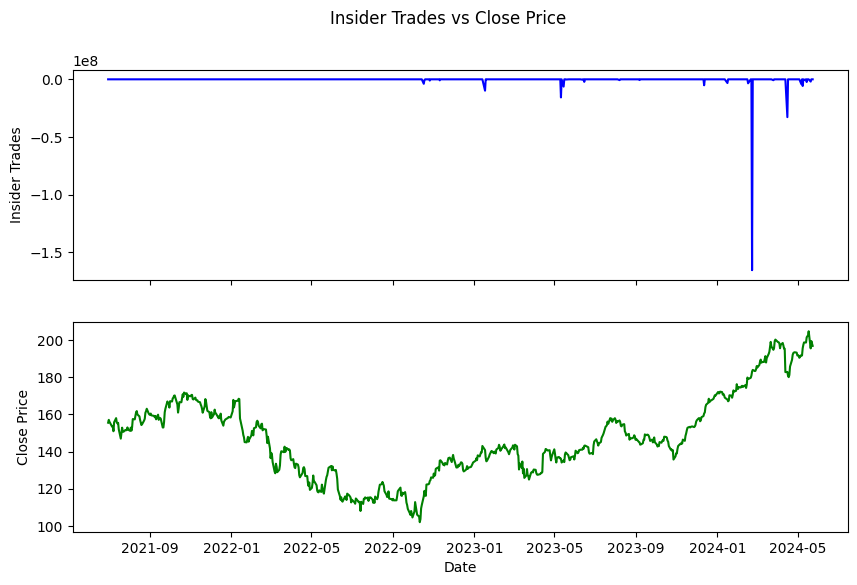

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax1.plot(newdata['Date'], newdata['Insider_Trades'], color='blue')
ax2.plot(newdata['Date'], newdata['Close'], color='green')

ax1.set_ylabel('Insider Trades')
ax2.set_ylabel('Close Price')
ax2.set_xlabel('Date')
plt.suptitle('Insider Trades vs Close Price')

plt.show()

In [10]:
# print(newdata['Close'], newdata['Total_Count'])
# print(np.corrcoef(newdata['Close'], newdata['Total_Count'])[0, 1])
# print(newdata['Date'][::-1][:(int(len(news) * 1.2))])

newdata = newdata[::-1][:int(len(news) * 1.2)]
print(newdata['Total_Count'])
newdata['Total_Count'] = newdata['Total_Count'].shift(periods=1)
print(newdata)[:5]

print(np.corrcoef(newdata['Close'], newdata['Total_Count'])[0, 1])

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot Negative Sentiment as a bar chart
ax1.bar(newdata['Date'], newdata['Negative_Count'], color='red', label='Negative Sentiment')
# Plot Positive Sentiment as a bar chart
ax1.bar(newdata['Date'], newdata['Positive_Count'], color='green', label='Positive Sentiment')
# Plot Overall Sentiment as a bar chart
ax1.bar(newdata['Date'], newdata['Total_Count'], color='blue', label='Overall Sentiment')

# Plot Close Price
ax2.plot(newdata['Date'], newdata['Close'], color='green', label='Close Price')

# Set y-axis labels
ax1.set_ylabel('Sentiment Count')
ax2.set_ylabel('Close Price')

# Set x-axis label
ax2.set_xlabel('Date')

# Add legend to ax1
ax1.legend()

# Set title for the entire plot
plt.suptitle('News Sentiment vs Close Price')

# Show plot
plt.show()

729   -5.0
728    2.0
727   -1.0
726    0.0
725    1.0
724    0.0
723    2.0
722    2.0
721    0.0
720    0.0
719   -1.0
718    0.0
717    0.0
716    0.0
715    0.0
714   -2.0
713   -3.0
712    0.0
711   -2.0
710    0.0
709   -2.0
708   -1.0
707   -2.0
706    0.0
705    0.0
704    0.0
703    0.0
Name: Total_Count, dtype: float64
          Date       Close    Volume  Insider_Trades  Negative_Count  \
729 2024-05-23  196.919998   8067400             0.0            -5.0   
728 2024-05-22  198.309998   9425300             0.0             0.0   
727 2024-05-21  199.520004  14420800             0.0            -2.0   
726 2024-05-20  195.580002  17373300      -1948851.0            -2.0   
725 2024-05-17  204.789993   9260500             0.0             0.0   
724 2024-05-16  202.470001   8497900             0.0             0.0   
723 2024-05-15  202.110001   8370000             0.0             0.0   
722 2024-05-14  201.509995   8596200      -2347065.0             0.0   
721 2024-05-13  198.7

TypeError: 'NoneType' object is not subscriptable

    Unnamed: 0        Date       Close    Volume  Insider_Trades  \
0          703  2024-04-17  180.080002   9017100             0.0   
1          704  2024-04-18  181.250000   9557700             0.0   
2          705  2024-04-19  185.800003  13380200             0.0   
3          706  2024-04-22  189.410004  11529700             0.0   
4          707  2024-04-23  192.139999   9144400             0.0   
5          708  2024-04-24  193.080002   6964900             0.0   
6          709  2024-04-25  193.369995   9802300             0.0   
7          710  2024-04-26  193.490005   6413700             0.0   
8          711  2024-04-29  193.279999   5387800             0.0   
9          712  2024-04-30  191.740005   8153700             0.0   
10         713  2024-05-01  191.860001   7445300             0.0   
11         714  2024-05-02  191.660004   6501700             0.0   
12         715  2024-05-03  190.509995   8922800             0.0   
13         716  2024-05-06  192.000000   7911100

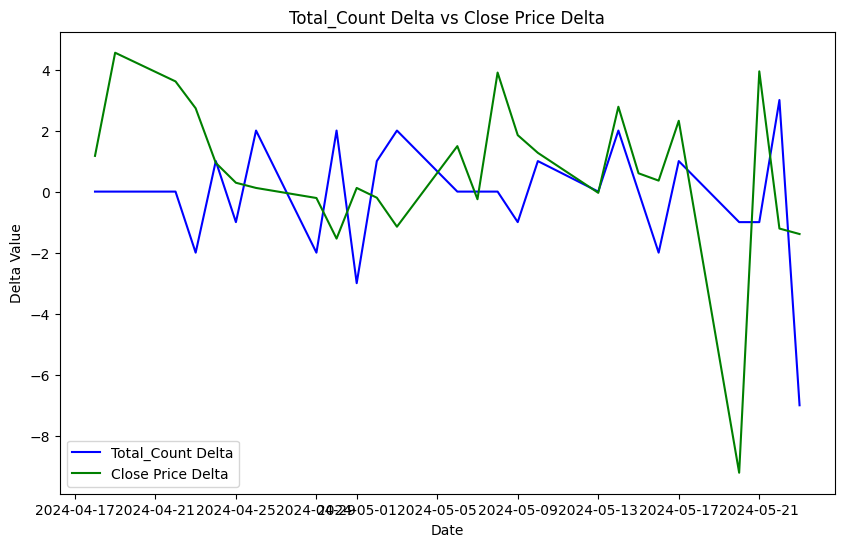

In [12]:
TODO: SHIFT BACK????++

import pandas as pd
import matplotlib.pyplot as plt

data_path = 'subset.csv'
newdata = pd.read_csv(data_path)
print(newdata)

# Convert 'Date' column to datetime
newdata['Date'] = pd.to_datetime(newdata['Date'])

# Calculate the difference (delta) for 'Total_Count' and 'Close'
total_count_delta = newdata['Total_Count'].diff()
close_delta = newdata['Close'].diff()

# Calculate correlation coefficient between 'Close' and 'Total_Count' deltas
correlation_delta = close_delta.corr(total_count_delta)

print("Correlation coefficient between 'Close' and 'Total_Count' deltas:", correlation_delta)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(newdata['Date'], total_count_delta, label='Total_Count Delta', color='blue')
plt.plot(newdata['Date'], close_delta, label='Close Price Delta', color='green')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Delta Value')
plt.title('Total_Count Delta vs Close Price Delta')
plt.legend()

# Show plot
plt.show()
